# Facial Emotion Recognition

**Introduction**

Facial emotion recognition using Convolutional Neural Networks (CNN) is a technique to recognize human emotions from facial expressions in images.
The objective of this project is to categorize each face based on the emotion shown in the facial expression into one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).

**Approach**

* A CNN model is trained on the FER dataset to learn the features of facial expressions that are associated with each emotion.
* The model uses convolutional layers to extract features from the input images and pooling layers to reduce the dimensionality of the feature maps.
* The extracted features are then fed into fully connected layers to classify the emotion.

**Dataset Description**
* The dataset consists of a collection of grayscale images (48x48 pixel) of human faces, where each image is labeled with one of seven basic emotions: anger, disgust, fear, happiness, sadness, surprise, or neutral.
* The training set consists of 28,709 examples.
The test set consists of over 7,000 samples

**Importing Libraries**

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping

**Loading the Dataset**

In [2]:
train_dir = "/kaggle/input/fer2013/train"  # train data folder
test_dir = "/kaggle/input/fer2013/test"    # test data folder

Creating a function to do the following
* It takes in the folder name as input and loads all the images in that folder along with their corresponding labels.
* It then loops through all the subfolders (labels) in the given folder and then loops through all the files (images) in each subfolder.
* For each image file, it constructs the full path of the image using and appends it to the image_paths list. The corresponding label is also appended to the labels list.
* Finally, the function returns the two lists.

In [3]:
def load_dataset(directory):
    image_paths = []
    labels = []
    
    for label in os.listdir(directory):
      
        for filename in os.listdir(directory+"/"+label):
            image_path = os.path.join(directory, label, filename)
            image_paths.append(image_path)
            labels.append(label)

    return image_paths, labels

In [4]:
## convert into dataframe
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(train_dir)
train.head()

,image,label
0,/kaggle/input/fer2013/train/surprise/Training_...,surprise
1,/kaggle/input/fer2013/train/surprise/Training_...,surprise
2,/kaggle/input/fer2013/train/surprise/Training_...,surprise
3,/kaggle/input/fer2013/train/surprise/Training_...,surprise
4,/kaggle/input/fer2013/train/surprise/Training_...,surprise


In [5]:
train.tail()

,image,label
28704,/kaggle/input/fer2013/train/happy/Training_188...,happy
28705,/kaggle/input/fer2013/train/happy/Training_165...,happy
28706,/kaggle/input/fer2013/train/happy/Training_108...,happy
28707,/kaggle/input/fer2013/train/happy/Training_304...,happy
28708,/kaggle/input/fer2013/train/happy/Training_956...,happy


In [6]:
train.shape

(28709, 2)

In [7]:
train['label'].value_counts()

happy       7215
neutral     4965
sad         4830
fear        4097
angry       3995
surprise    3171
disgust      436
Name: label, dtype: int64

**Similarly, construct a dataframe for Test data**

In [8]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(test_dir)
test.head()

,image,label
0,/kaggle/input/fer2013/test/surprise/PublicTest...,surprise
1,/kaggle/input/fer2013/test/surprise/PrivateTes...,surprise
2,/kaggle/input/fer2013/test/surprise/PrivateTes...,surprise
3,/kaggle/input/fer2013/test/surprise/PublicTest...,surprise
4,/kaggle/input/fer2013/test/surprise/PrivateTes...,surprise


In [9]:
test.shape

(7178, 2)

In [10]:
test['label'].value_counts()

happy       1774
sad         1247
neutral     1233
fear        1024
angry        958
surprise     831
disgust      111
Name: label, dtype: int64

In [11]:
img_shape = 48
batch_size = 64
train_data_path = '../input/fer2013/train/'
test_data_path = '../input/fer2013/test/'

# Preprocssing

Preprocessing images is an essential step when training a CNN model because it can significantly improve the performance and accuracy of the model. Here are some reasons why we preprocess images:

1. Standardization: Preprocessing can help standardize the input data, which is important for the CNN model to learn patterns effectively. Standardization can involve scaling the pixel values to a specific range (e.g., 0-1) or subtracting the mean pixel value from each pixel.


2. Noise reduction: Preprocessing can help remove unwanted noise or artifacts from the image, which can improve the model's ability to learn relevant features.


3. Augmentation: Preprocessing can also involve data augmentation techniques such as flipping, rotation, and cropping. This can increase the diversity of the training data and prevent overfitting, leading to a more robust and generalizable model.

4. Feature extraction: Some preprocessing techniques such as edge detection or color segmentation can extract important features from the image, which can be used as input to the CNN model.

In summary, preprocessing is crucial in preparing the input data for the CNN model to effectively learn the relevant features and improve its performance.


We will use ImageDataGenerator here which provides a set of functions to perform a variety of data augmentation techniques on images such as rotation, scaling, flipping, shifting, and more. It can also be used to normalize the pixel values of images and to generate batches of images for training a deep learning model.

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
        rescale = 1 / 255.,
        # Data Augmentation
        rotation_range=10,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,                                        
        fill_mode='nearest',
    )


test_datagen = ImageDataGenerator(
    rescale = 1 / 255.,
)



train_data = train_datagen.flow_from_directory(
    train_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode='rgb', 
    shuffle=True,
    batch_size=batch_size,
    subset='training', 
)


test_data = test_datagen.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size,
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


The train_datagen object is an instance of ImageDataGenerator class that applies data augmentation to the training images. The rescale parameter scales the pixel values of the image by a factor of 1/255 to make them fall in the range of 0 to 1. The rotation_range, zoom_range, width_shift_range, height_shift_range, and horizontal_flip parameters are used to apply various transformations to the images to augment the dataset. The fill_mode parameter is used to specify how the pixels outside the boundaries of the image are filled after the transformation.

The test_datagen object is also an instance of ImageDataGenerator class but it does not perform any data augmentation, it only scales the pixel values of the test images by a factor of 1/255.

The class_mode parameter is set to "categorical" which means that the labels are one-hot encoded. The target_size parameter is used to resize the images to a fixed size, and the color_mode parameter specifies the color space of the image. The shuffle parameter is used to shuffle the order of the images in each batch, and the batch_size parameter specifies the number of images in each batch.



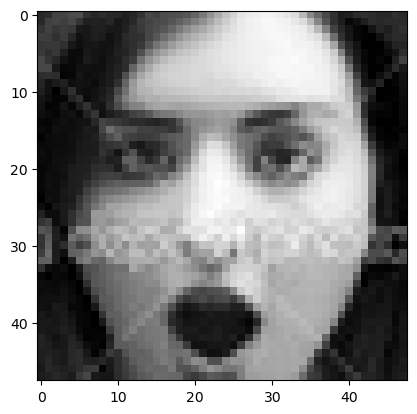

In [13]:
from PIL import Image
# Load image using Pillow
img = Image.open(train['image'][0])
plt.imshow(img, cmap='gray');

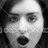

In [14]:
img

**Check the Image size**

* size attribute returns a tuple of the width and height of the image in pixels.
* 'img.getbands()' method returns a tuple of the band names in the image. 

For example, an RGB image has three bands: red, green, and blue.
If the image is grayscale, getbands method of the image object will return a tuple containing a single string element "L". "L" stands for "Luminance", which is the intensity of the pixel's brightness.

In [15]:
shape = img.size + img.getbands() 
print("The shape of the image is:", shape)

The shape of the image is: (48, 48, 'L')


In [16]:
def resizing(images):
    features = []
    for image in tqdm(images):
        img = Image.open(image)
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features), 48, 48, 1)
    return features

* The above function takes a list of image paths as input, opens each image using the PIL Image module, converts it into a numpy array and appends it to a list called features.

* The tqdm() function is used to display a progress bar during the loop execution.

* After processing all images in the input list, the features list is converted into a numpy array and reshaped into a four-dimensional array with dimensions (number of samples, height, width, channels),

* Each image is resized to a square image with dimensions 48x48 and a single color channel, which is suitable for inputting into a neural network.

In [17]:
train_features = resizing(train['image'])

  0%|          | 0/28709 [00:00<?, ?it/s]

In [18]:
train_features.shape

(28709, 48, 48, 1)

In [19]:
test_features = resizing(test['image'])

  0%|          | 0/7178 [00:00<?, ?it/s]

In [20]:
test_features.shape

(7178, 48, 48, 1)

In [21]:
## normalize the image
x_train = train_features/255
x_test = test_features/255

Normalizing images is a common pre-processing step for training Convolutional Neural Networks (CNNs). This step involves adjusting the pixel values of an image so that they have zero mean and unit variance. This helps us in these ways:  
* To speed up convergence
* To improve performance
* To reduce overfitting

In [22]:
## Encoding the output column (label)

from sklearn.preprocessing import LabelEncoder
la = LabelEncoder()
la.fit(train['label'])
y_train = la.transform(train['label'])
y_test = la.transform(test['label'])

LabelEncoder is a class in the scikit-learn library of Python that is used to transform categorical labels into numerical labels. It is commonly used in machine learning tasks to preprocess categorical data before fitting the model.

The LabelEncoder class has two main methods: fit and transform. The fit method takes an array-like object of the categorical labels and identifies the unique categories in the data. The transform method takes the same array-like object and returns an array of the corresponding numerical labels.

In [23]:
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

This code converts the integer-encoded class labels for the training and testing datasets into one-hot encoded vectors using the to_categorical function from the Keras API of TensorFlow.


The to_categorical function converts each integer-encoded class label into a binary vector of length num_classes, where the index corresponding to the class label is set to 1 and all other indices are set to 0. For example, if a sample belongs to class 3 and num_classes is 7, the corresponding one-hot encoded vector will be [0, 0, 0, 1, 0, 0, 0].

In [24]:
y_train[0], y_train[-1]

(array([0., 0., 0., 0., 0., 0., 1.], dtype=float32),
 array([0., 0., 0., 1., 0., 0., 0.], dtype=float32))

# Model Creation

# Creating a neural network

**Convolutional Neural Network(CNN)**
CNN distinguishes meaningful features in an image in order to classify the image as a whole.Neural Networks are a subset of machine learning algorithms that are inspired by the structure and function of the human brain. They are designed to recognize complex patterns and relationships in data, and they have proven to be particularly effective in a wide range of applications, including image and speech recognition, natural language processing, and autonomous systems.

At their core, neural networks are comprised of interconnected nodes, or "neurons," which process and transmit information. The neurons are arranged into layers, with each layer processing a different aspect of the input data. The output of one layer is fed as input into the next layer, allowing the network to progressively learn more complex features and patterns.

During the training phase, the network is presented with a large dataset of labeled examples, and it adjusts the weights of the connections between the neurons in order to minimize the difference between its predicted output and the actual output. This process, known as backpropagation, allows the network to iteratively improve its performance and learn to make increasingly accurate predictions.

One of the key advantages of neural networks is their ability to learn from unstructured data, such as images, audio, and text. This has led to significant advances in fields such as computer vision, natural language processing, and speech recognition. However, neural networks can also be computationally intensive and require large amounts of data to train effectively.

Here are the key mathematical formulas used in CNN:

1. **Convolution operation** :  The convolution operation involves sliding a filter or kernel over the input image to perform element-wise multiplication and summation, as shown below

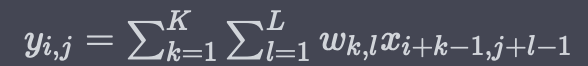

where $y_{i,j}$ is the output feature map at position $(i,j)$, $w_{k,l}$ is the weight of the filter at position $(k,l)$, $x_{i+k-1,j+l-1}$ is the input pixel value at position $(i+k-1,j+l-1)$, and $K$ and $L$ are the dimensions of the filter.


2. **Activation function:** : After the convolution operation, an activation function is applied element-wise to introduce non-linearity. The most commonly used activation functions are ReLU (Rectified Linear Unit) and sigmoid. The ReLU function is defined as:

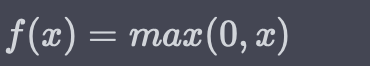


3. **Pooling operation** : The pooling operation is used to reduce the spatial dimension of the feature maps and introduce translation invariance. The most commonly used pooling operation is max pooling, which involves taking the maximum value within a pooling window. The output of the pooling operation can be calculated as:

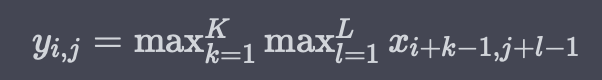

where $y_{i,j}$ is the output value at position $(i,j)$, $x_{i+k-1,j+l-1}$ is the input value at position $(i+k-1,j+l-1)$, and $K$ and $L$ are the dimensions of the pooling window.

4. **Softmax function** : The softmax function is typically used in the output layer of a CNN for classification problems. It converts the output of the network into a probability distribution over the classes. The softmax function can be defined as:

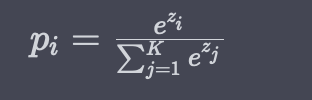

where $p_i$ is the probability of the $i$th class, $z_i$ is the output of the network for the $i$th class, and $K$ is the total number of classes


# Principles of CNN

**Convolution**

A convolution sweeps the window through images then calculates its input and filter dot product pixel values. This allows convolution to emphasize the relevant features.

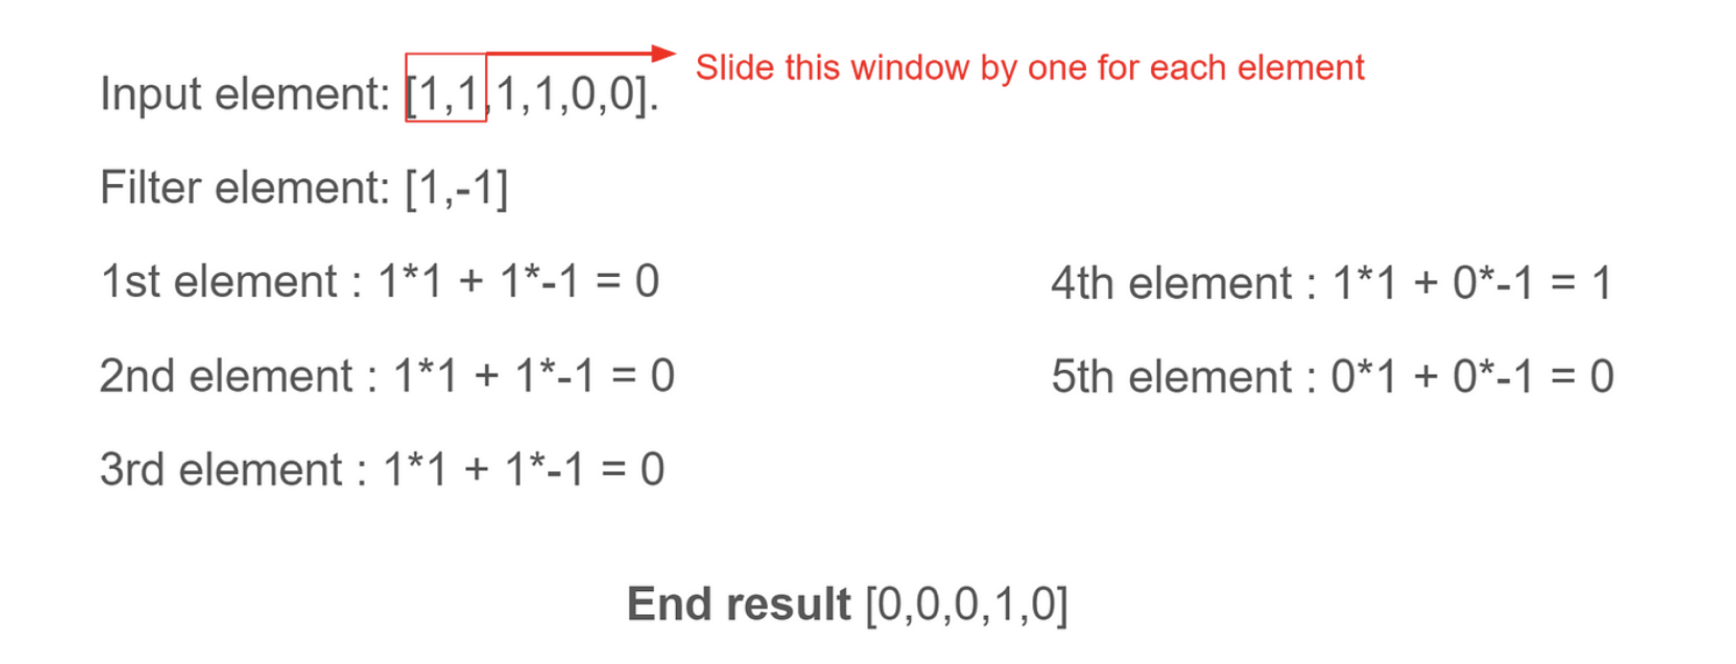

Mathematical Equation 
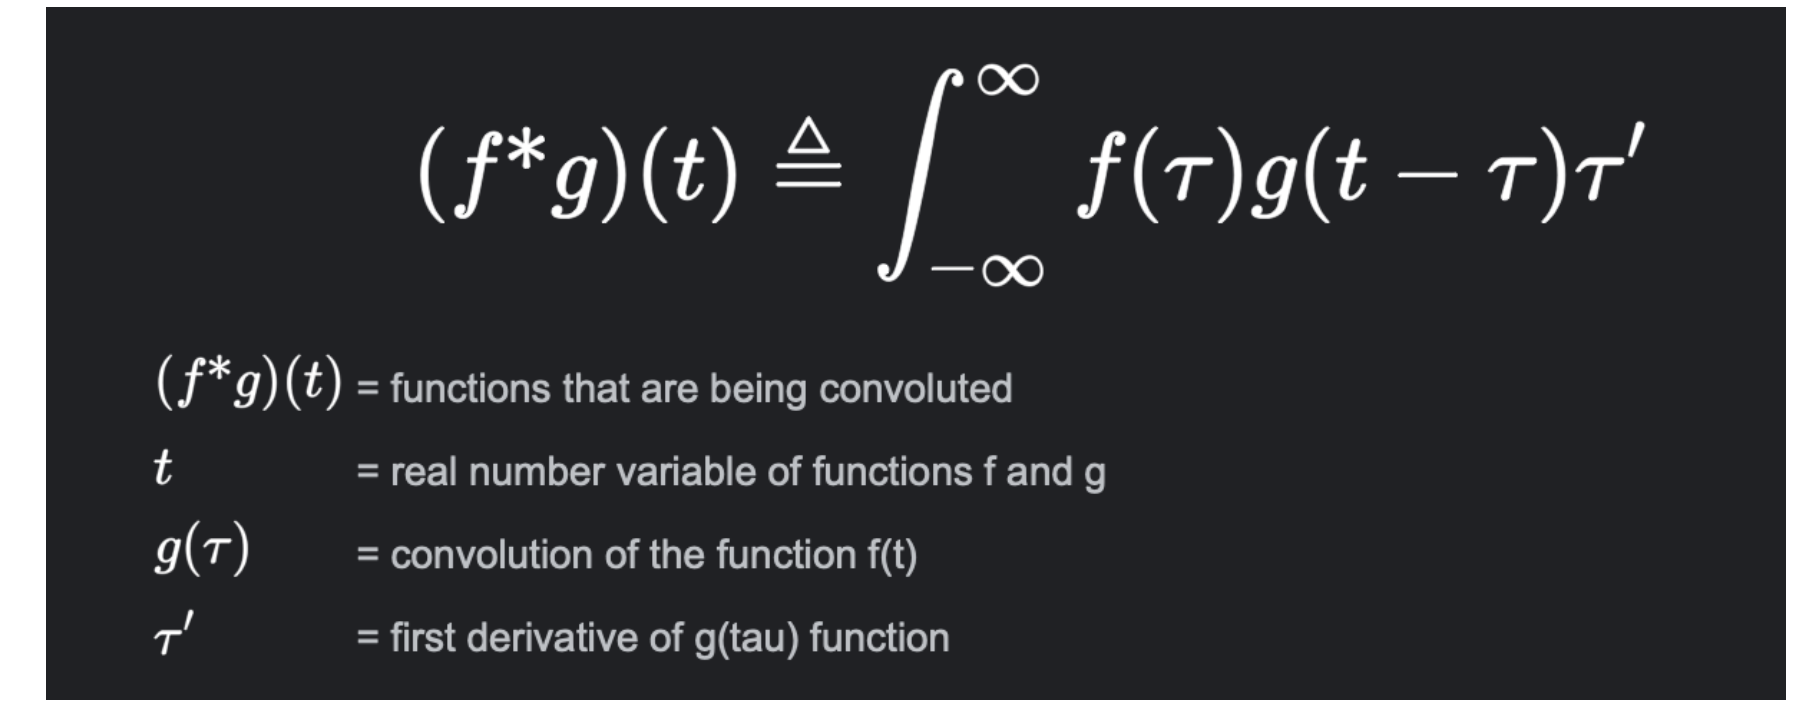

Look at this input. We will encase the window elements with a small window, dot multiplies it with the filter elements, and save the output. We will repeat each operation to derive 5 output elements as [0,0,0,1,0]. From this output, we can know that the feature change(1 becomes 0) in sequence 4. The filter has done well to identify the input values. Similarly, this happened for 2D Convolutions as well.

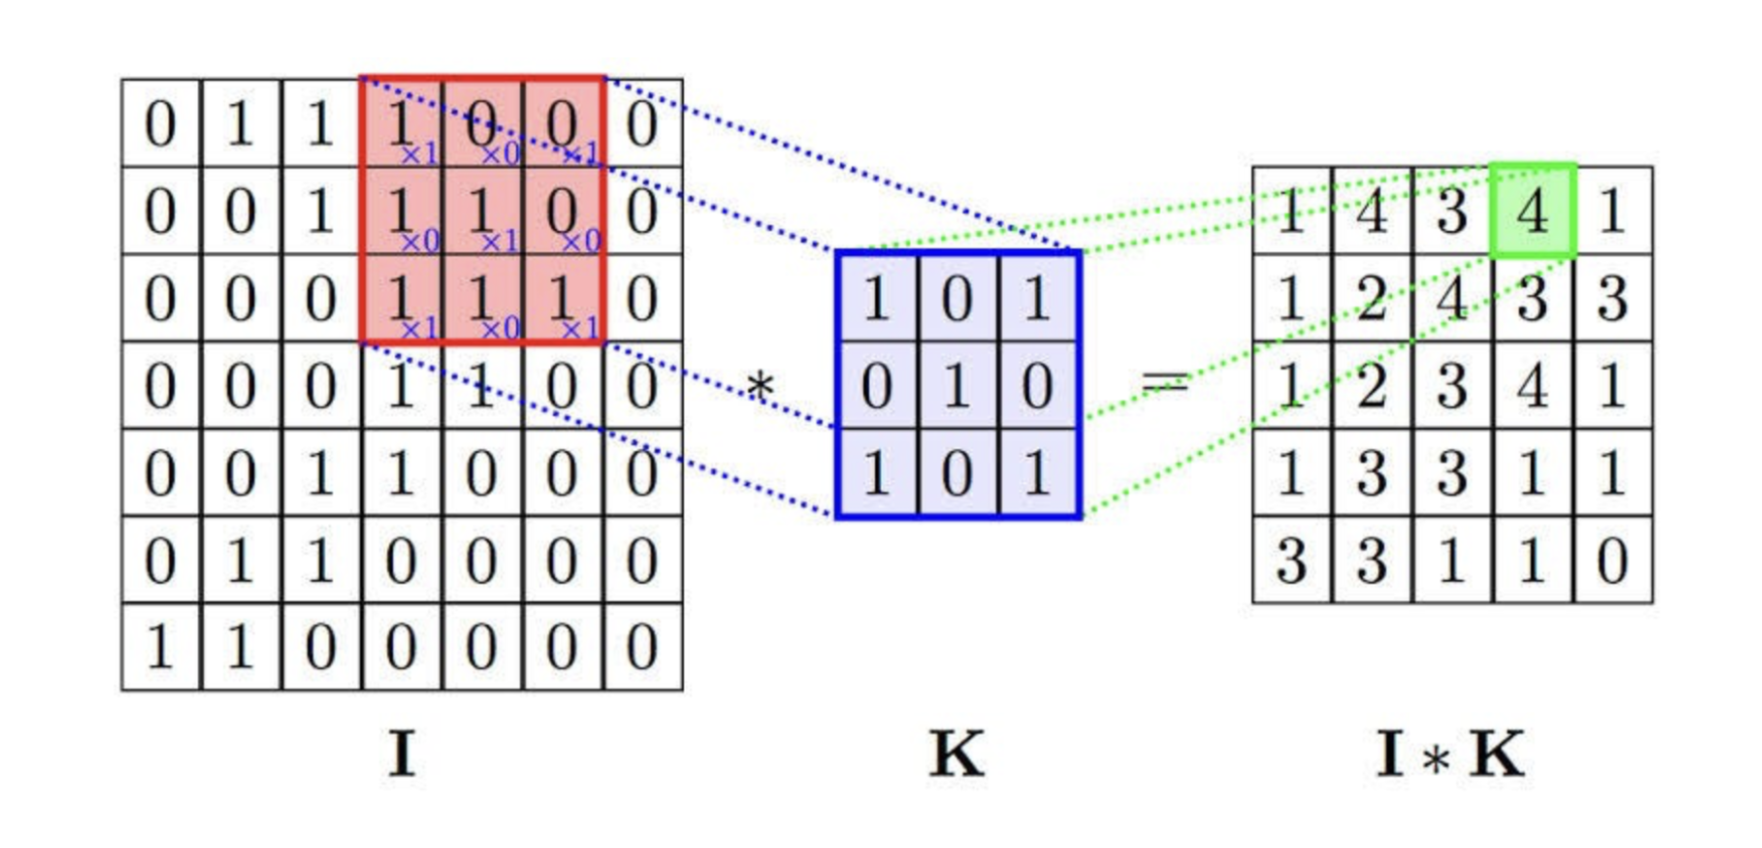

**Max Pooling**

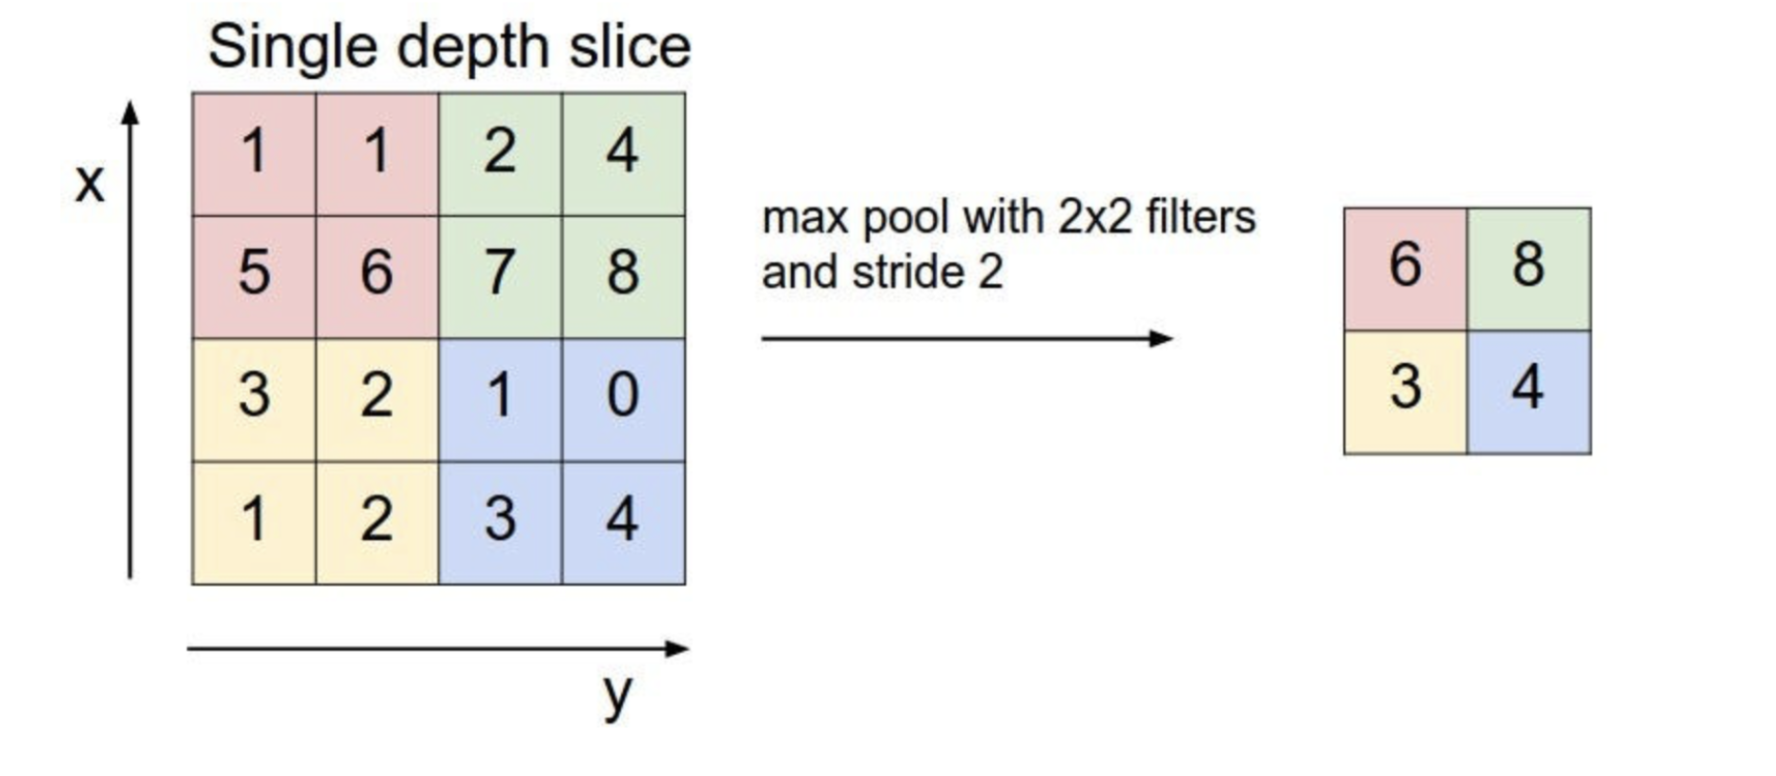

CNN uses max pooling to replace output with a max summary to reduce data size and processing time. This allows you to determine features that produce the highest impact and reduces the risk of overfitting. Max pooling takes two hyperparameters: stride and size. The stride will determine the skip of value pools while the size will determine how big the value pools in every skip.

Mathematical Euation
y[i,j] = max_{m=0}^{p-1} max_{n=0}^{p-1} x[i*p+m,j*p+n]

Here, x is the input feature map, y is the resulting pooled feature map, p is the pooling size, and the max is taken over all the elements in each pooling window.

**Activation Function (ReLU and Sigmoid)**

After each convolutional and max pooling operation, we can apply Rectified Linear Unit (ReLU). The ReLU function mimics our neuron activations on a “big enough stimulus” to introduce nonlinearity for values x>0 and returns 0 if it does not meet the condition. This method has been effective to solve diminishing gradients. Weights that are very small will remain as 0 after the ReLU activation function.

Relu Equation :   f(x) = max(0, x)
Here, x is the input to the activation function.

SoftMax Equation :     f(x_i) = exp(x_i) / sum_{j=1}^K exp(x_j)
Here, x_i is the input to the activation function for the i-th class, K is the total number of classes, and the sum is taken over all the classes.


**The CNN Big Picture + Fully Connected Layer**

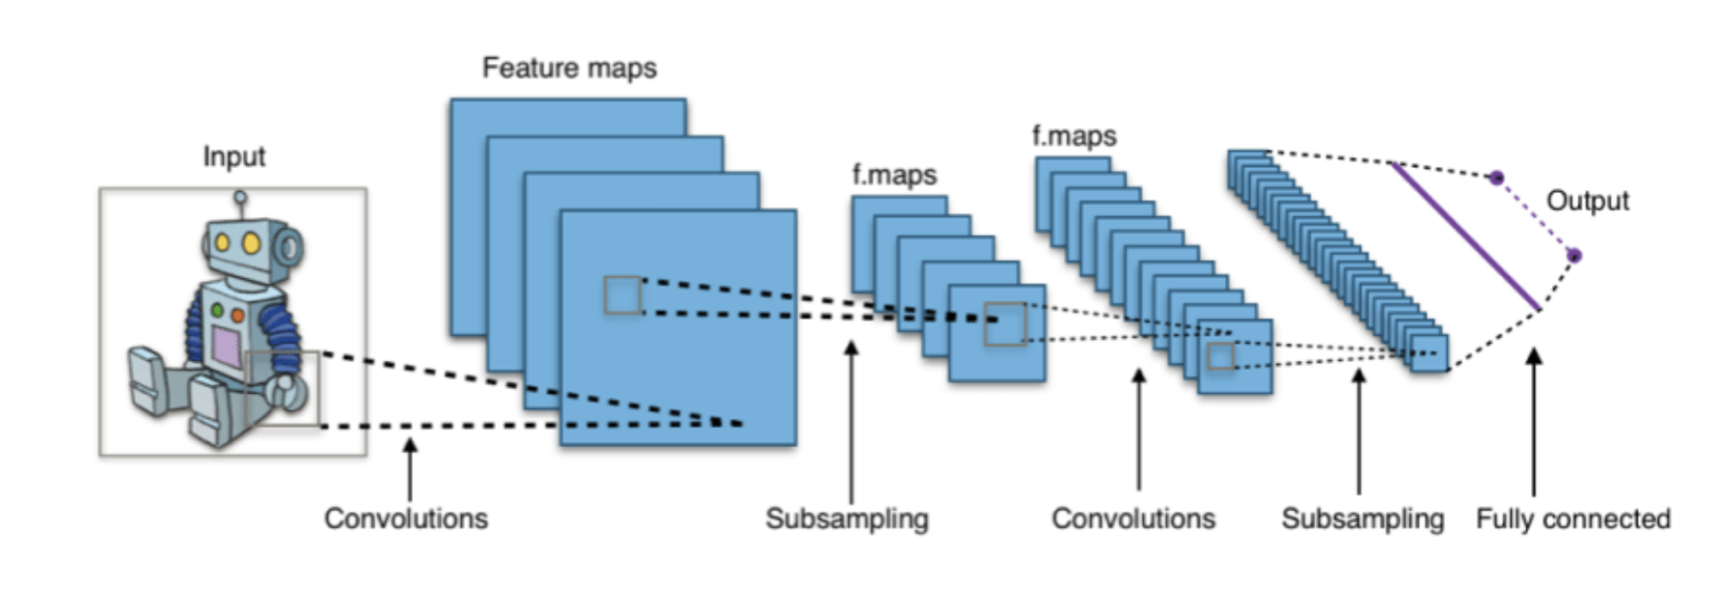

Finally, we will serve the convolutional and max pooling feature map outputs with Fully Connected Layer (FCL). We flatten the feature outputs to column vector and feed-forward it to FCL. We wrap our features with softmax activation function which assign decimal probabilities for each possible label which add up to 1.0. Every node in the previous layer is connected to the last layer and represents which distinct label to output.

Initializing Sequential Model.

**This CNN has 4 convolution layers and 3 fully connected layers.**

Convolution layers have 64 filters of 3x3 pixels. Since the image is 28x28 pixel, 3x3 should be a reasonable small

Using **BatchNormalization** to standardize the input, **max pooler** to make the result become smaller after filter, **relu** activation function in all convolutional layers

In conclusion, CNNs are a powerful type of neural network that are widely used in computer vision tasks such as image classification, object detection, and segmentation. They work by learning a set of filters or kernels that can recognize patterns in the input data. The filters are convolved with the input image to produce a set of feature maps, which are then passed through activation functions and pooling layers to reduce their dimensionality and introduce non-linearity and translation invariance. Finally, the feature maps are flattened and fed into fully connected layers to perform the final classification or regression task. By using convolutions and sharing weights across the input image, CNNs are able to learn features that are translation invariant and can recognize patterns in different parts of the image, making them highly effective for a wide range of computer vision applications.

In [25]:
from keras.layers import BatchNormalization

def Create_CNN_Model():
    
    model = Sequential()
    
    #CNN1
    model.add(Conv2D(32, (3,3), activation='relu', input_shape=(img_shape, img_shape, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(64,(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.25))
    
    #CNN2
    model.add(Conv2D(64, (3,3), activation='relu', ))
    model.add(BatchNormalization())
    model.add(Conv2D(128,(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.25))
    
    #CNN3
    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(256,(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.25))
    
    
    #Output
    model.add(Flatten())
    
    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(7,activation='softmax'))
    
    
    return model

This is a CNN model that consists of 3 sets of convolutional layers followed by max pooling, batch normalization, and dropout layers to prevent overfitting. The output of the convolutional layers is then flattened and passed through a set of fully connected layers with batch normalization and dropout to perform the final classification task. The model uses the 'relu' activation function for the convolutional and dense layers, and the 'softmax' activation function for the output layer since it is a multi-class classification problem.

In [26]:
CNN_Model = Create_CNN_Model()
CNN_Model.summary()
CNN_Model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 46, 46, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 64)       0         
 )                                                               
                                                        

In [27]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
checkpoint_path = "CNN_Model_Checkpoint"

Checkpoint = ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True)

# Create Early Stopping Callback to monitor the accuracy
Early_Stopping = EarlyStopping(monitor = 'val_accuracy', patience = 15, restore_best_weights = True, verbose=1)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning rate
Reducing_LR = tf.keras.callbacks.ReduceLROnPlateau( monitor='val_loss',
                                                  factor=0.2,
                                                  patience=2,
#                                                   min_lr=0.000005,
                                                  verbose=1)

callbacks = [Early_Stopping, Reducing_LR]

steps_per_epoch = train_data.n // train_data.batch_size
validation_steps = test_data.n // test_data.batch_size

This code defines and sets up three different callbacks for training a Convolutional Neural Network (CNN) using the Keras API of TensorFlow.

1. **ModelCheckpoint**: This callback saves the best weights of the model during training, based on the validation accuracy. The saved weights can be used to reload the best performing model and continue training from there. The checkpoint_path variable specifies the directory path where the weights will be saved.

2. **EarlyStopping**: This callback monitors the validation accuracy of the model and stops the training process early if the accuracy does not improve for a certain number of epochs (patience) specified by the user. The restore_best_weights parameter ensures that the best weights of the model are loaded when the training is stopped.

3. **ReduceLROnPlateau**: This callback reduces the learning rate of the optimizer if the validation loss does not improve for a certain number of epochs (patience) specified by the user. This helps to prevent overfitting and allows the model to converge better. The factor parameter specifies the factor by which the learning rate will be reduced, and the verbose parameter controls the verbosity of the output.

The steps_per_epoch and validation_steps variables define the number of steps (batches) per epoch for the training and validation data, respectively. These values are calculated by dividing the total number of samples in the data by the batch size of the data generator.





In [28]:
CNN_history = CNN_Model.fit(train_data , validation_data= test_data , epochs=20, batch_size= batch_size,
                            callbacks=callbacks, steps_per_epoch= steps_per_epoch, validation_steps=validation_steps) 

Epoch 1/20


2023-04-24 10:49:17.567773: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


448/448 [==============================] - 79s 144ms/step - loss: 2.0419 - accuracy: 0.2095 - val_loss: 1.8045 - val_accuracy: 0.2621 - lr: 0.0010
Epoch 2/20
448/448 [==============================] - 61s 135ms/step - loss: 1.7791 - accuracy: 0.2745 - val_loss: 1.7400 - val_accuracy: 0.3030 - lr: 0.0010
Epoch 3/20
448/448 [==============================] - 62s 139ms/step - loss: 1.6623 - accuracy: 0.3374 - val_loss: 1.6247 - val_accuracy: 0.3743 - lr: 0.0010
Epoch 4/20
448/448 [==============================] - 58s 129ms/step - loss: 1.5382 - accuracy: 0.3974 - val_loss: 1.6407 - val_accuracy: 0.3368 - lr: 0.0010
Epoch 5/20
448/448 [==============================] - 58s 130ms/step - loss: 1.4418 - accuracy: 0.4421 - val_loss: 1.5560 - val_accuracy: 0.3982 - lr: 0.0010
Epoch 6/20
448/448 [==============================] - 58s 130ms/step - loss: 1.3703 - accuracy: 0.4761 - val_loss: 1.3002 - val_accuracy: 0.4983 - lr: 0.0010
Epoch 7/20
448/448 [==============================] - 58s 130ms

The epochs parameter specifies the number of times the model will iterate over the entire training dataset. The batch_size parameter specifies the number of samples per batch that will be fed to the model during training.

The CNN_Model.fit method returns a history object, which contains information about the training history of the model, including the loss and accuracy metrics for both the training and validation datasets at each epoch.

Overall, this code trains a CNN model using the Keras API of TensorFlow, with the specified parameters and callbacks, and saves the training history in the CNN_history variable.

In [29]:
CNN_Score = CNN_Model.evaluate(test_data)

print("    Test Loss: {:.5f}".format(CNN_Score[0]))
print("Test Accuracy: {:.2f}%".format(CNN_Score[1] * 100))

113/113 [==============================] - 7s 59ms/step - loss: 0.9668 - accuracy: 0.6378
    Test Loss: 0.96680
Test Accuracy: 63.78%


In some cases, a test accuracy of 64.78% may be considered good, while in other cases it may not be sufficient. For example, in a highly complex and difficult image recognition task, achieving a test accuracy of 64.78% may be considered impressive. On the other hand, in a simple classification task with only a few categories, achieving such an accuracy level may not be considered impressive.

In [30]:
CNN_Score = CNN_Model.evaluate(train_data)

print("    Train Loss: {:.5f}".format(CNN_Score[0]))
print("Train Accuracy: {:.2f}%".format(CNN_Score[1] * 100))

449/449 [==============================] - 49s 110ms/step - loss: 0.9139 - accuracy: 0.6630
    Train Loss: 0.91392
Train Accuracy: 66.30%


In general, a lower training loss is better, as it indicates that the model is able to fit the training data more closely. However, a very low training loss may also indicate overfitting, which means that the model is too complex and may not generalize well to new data.

In [31]:
def plot_curves(history):

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"]))

    plt.figure(figsize=(15,5))

    #plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label = "training_loss")
    plt.plot(epochs, val_loss, label = "val_loss")
    plt.title("Loss")
    plt.xlabel("epochs")
    plt.legend()
    #plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label = "training_accuracy")
    plt.plot(epochs, val_accuracy, label = "val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("epochs")
    plt.legend()

The function then creates a figure with two subplots using the plt.subplots function from the matplotlib library. The left subplot shows the training and validation loss values over the epochs, while the right subplot shows the training and validation accuracy values over the epochs.

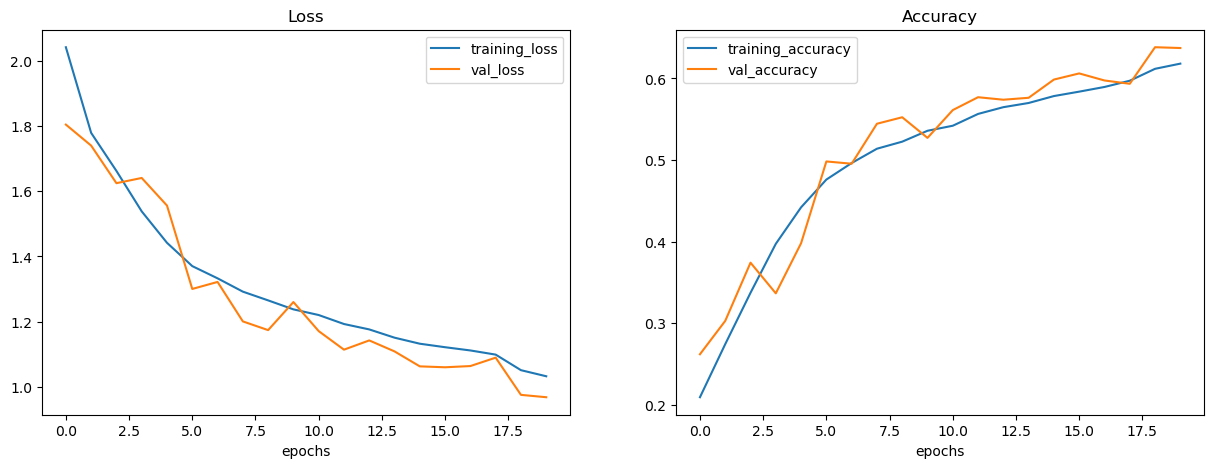

In [32]:
plot_curves(CNN_history)

Here we can observe that the validation loss and training loss both are decreasing trying to go below 1 which is a good thing as it will try to make accurate predictions. 

Observing the accuracy graphs we see that it is constantly increasing and trying to go above 64% which is a good thing, if we do hyperparameter tuning and increase the epochs than we can expect the accuracry to increase and cross 90% to get more accurate results  

In [33]:
CNN_Predictions = CNN_Model.predict(test_data)

# Choosing highest probalbilty class in every prediction 
CNN_Predictions = np.argmax(CNN_Predictions, axis=1)

113/113 [==============================] - 7s 57ms/step


# Confusion Matrix

A confusion matrix is a table used to evaluate the performance of a classification model by comparing the predicted class labels with the actual class labels. The table displays the number of true positive, false positive, true negative, and false negative predictions made by the model for each class.

In a binary classification problem, the confusion matrix has two rows and two columns, as follows:

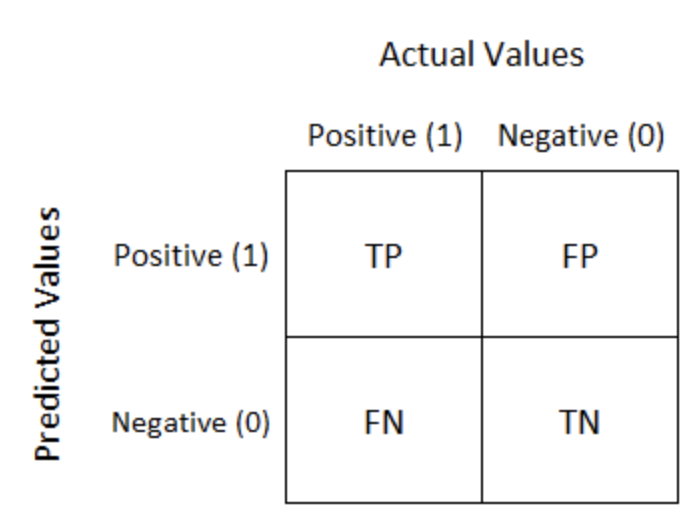

The true positive (TP) represents the number of positive cases correctly classified by the model, while the false positive (FP) represents the number of negative cases that were incorrectly classified as positive. The false negative (FN) represents the number of positive cases that were incorrectly classified as negative, and the true negative (TN) represents the number of negative cases correctly classified by the model.

The accuracy, precision, recall, and F1-score can be calculated using the values in the confusion matrix. The accuracy is the proportion of correct predictions made by the model, while the precision is the proportion of positive predictions that are correct. The recall (or sensitivity) is the proportion of actual positive cases that are correctly classified, and the F1-score is a measure of the trade-off between precision and recall.

Overall, the confusion matrix provides a comprehensive view of the performance of a classification model and can be used to identify specific areas for improvement. It is an important tool for evaluating the effectiveness of a model and making informed decisions about its deployment in real-world applications.

Text(0.5, 1.0, 'CNN Confusion Matrix')

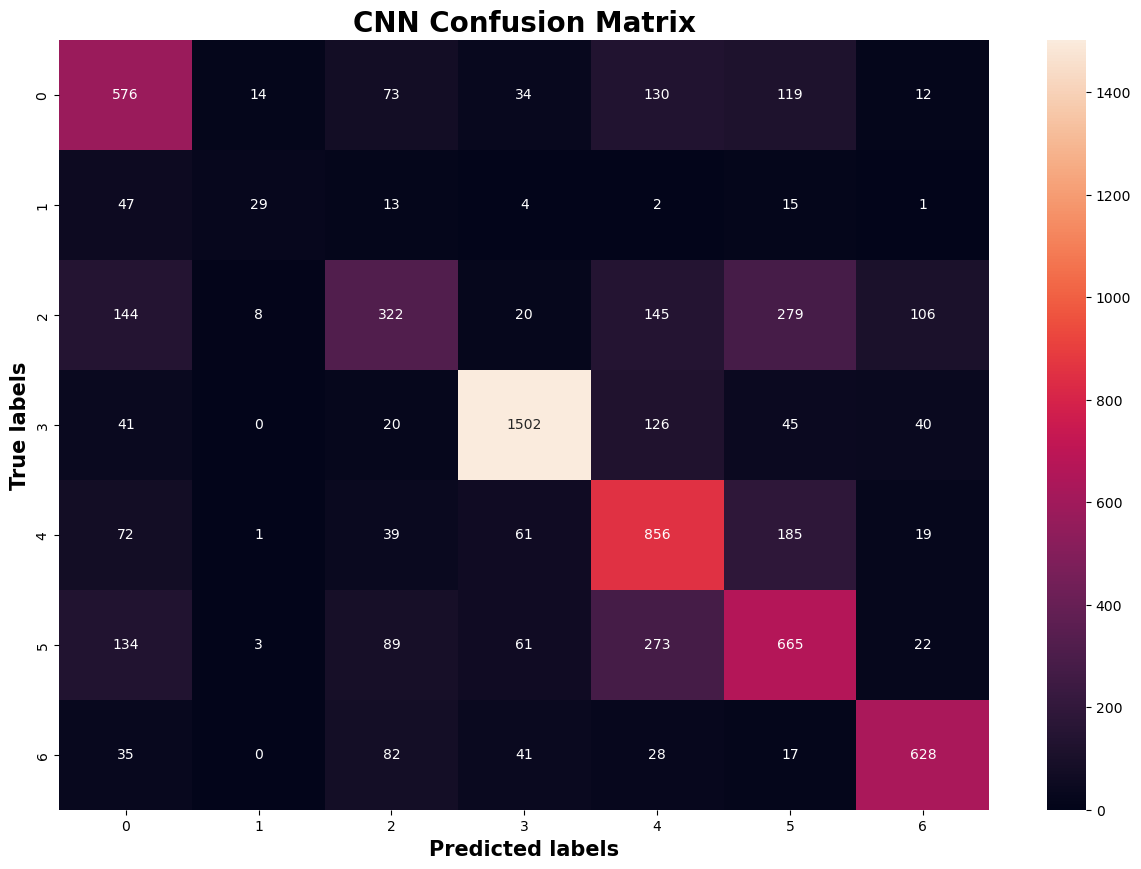

In [34]:
import seaborn as sns 
from sklearn.metrics import confusion_matrix

fig, ax= plt.subplots(figsize=(15,10))

cm=confusion_matrix(test_data.labels, CNN_Predictions)

sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels',fontsize=15, fontweight='bold')
ax.set_ylabel('True labels', fontsize=15, fontweight='bold')
ax.set_title('CNN Confusion Matrix', fontsize=20, fontweight='bold')

In [35]:
from sklearn.metrics import classification_report
# Print classification report and confusion matrix
print('Classification report:')
print(classification_report(test_data.labels, CNN_Predictions))

Classification report:
              precision    recall  f1-score   support

           0       0.55      0.60      0.57       958
           1       0.53      0.26      0.35       111
           2       0.50      0.31      0.39      1024
           3       0.87      0.85      0.86      1774
           4       0.55      0.69      0.61      1233
           5       0.50      0.53      0.52      1247
           6       0.76      0.76      0.76       831

    accuracy                           0.64      7178
   macro avg       0.61      0.57      0.58      7178
weighted avg       0.64      0.64      0.63      7178



The classification_report function generates a report that includes various performance metrics for each class, such as precision, recall, and F1-score, as well as an overall accuracy score. The report provides insights into how well the model is able to classify the different classes and can be used to evaluate the performance of the model.



In [36]:
Emotion_Classes = ['Angry', 
                  'Disgust', 
                  'Fear', 
                  'Happy', 
                  'Neutral', 
                  'Sad', 
                  'Surprise']

In [37]:
# Shuffling Test Data to show diffrent classes
test_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
    )

test_generator = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=True,
    batch_size=batch_size,
)

Found 7178 images belonging to 7 classes.


The test_preprocessor variable is an instance of the ImageDataGenerator class from the Keras API of TensorFlow, which is used to preprocess the test images. In this case, the images are rescaled by dividing each pixel value by 255 to normalize the pixel values between 0 and 1.

The flow_from_directory method returns a generator object, test_generator, which can be used to generate batches of preprocessed test data to feed to the model during evaluation. Each batch will contain batch_size number of preprocessed images and their corresponding one-hot encoded labels.

**Predict with test images**

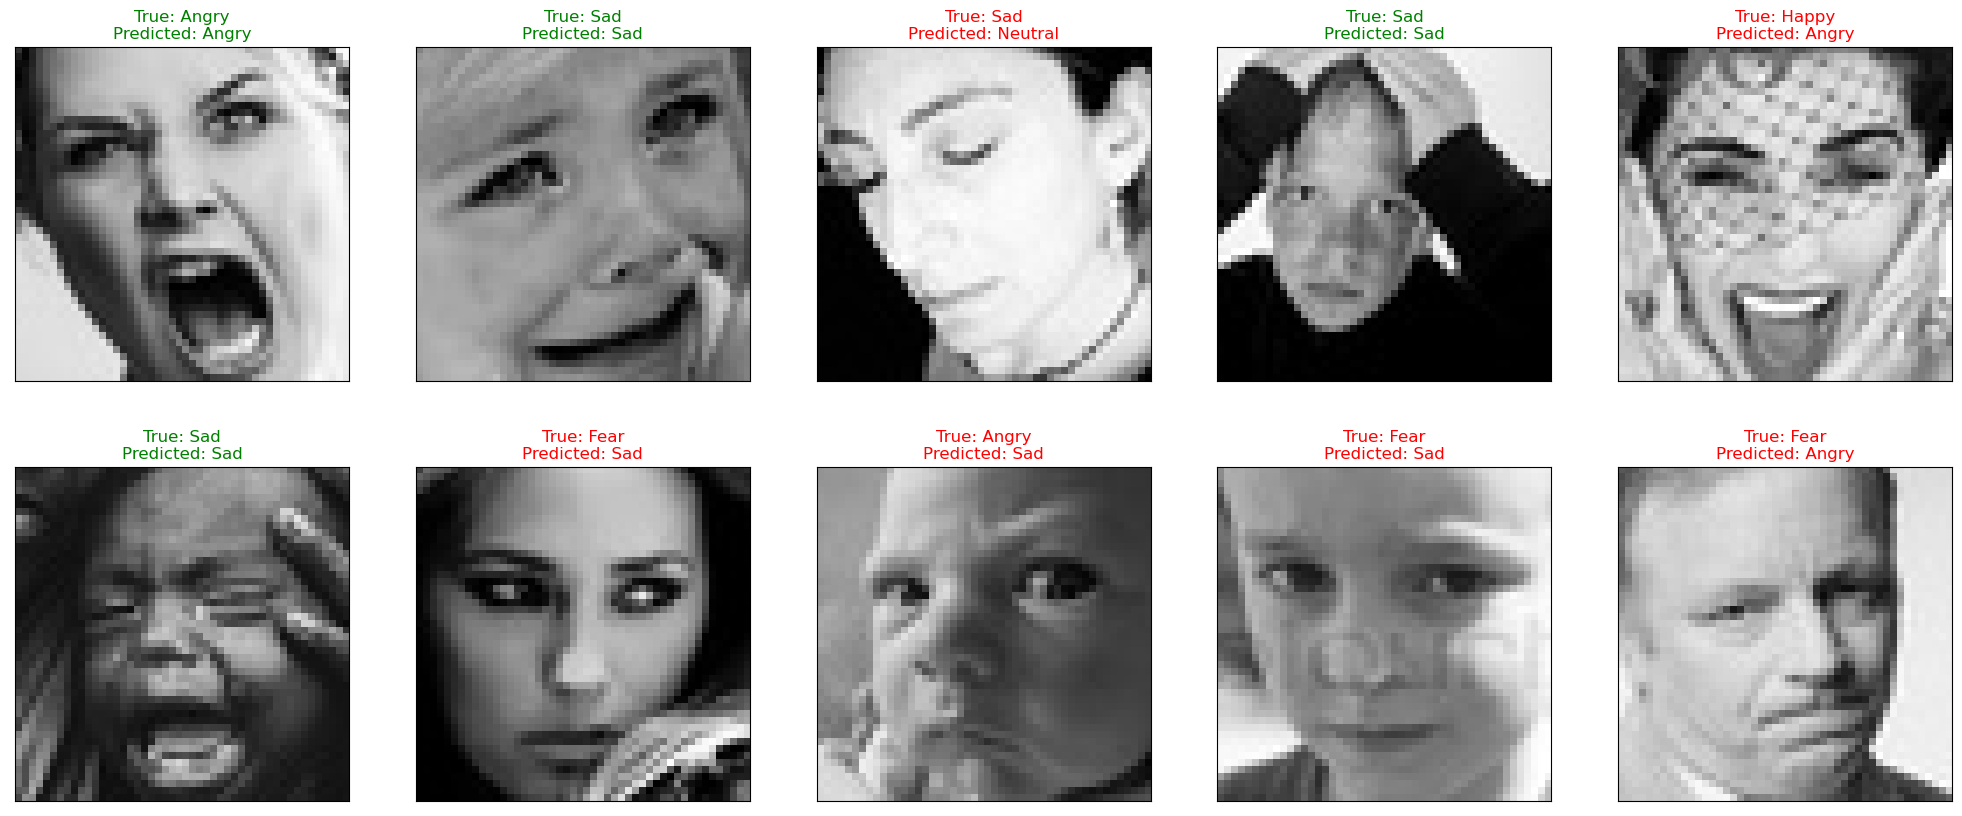

<Figure size 640x480 with 0 Axes>

In [38]:
# Display 10 random pictures from the dataset with their labels

Random_batch = np.random.randint(0, len(test_generator) - 1)

Random_Img_Index = np.random.randint(0, batch_size - 1 , 10)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):

    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]

    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]])

    Model_Prediction = np.argmax(CNN_Model.predict( tf.expand_dims(Random_Img, axis=0) , verbose=0))

    ax.imshow(Random_Img)

    if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction]:
          color = "green"
    else:
          color = "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)
plt.show()
plt.tight_layout()

# Ways to Improve the CNN model 

To improve the performance of a CNN model, we can try the following steps:

1. Increase the size of the model: Adding more layers or increasing the number of neurons in existing layers can increase the capacity of the model.
2. Change the model architecture: Experimenting with different types of layers, such as convolutional layers, pooling layers, and fully connected layers, and adding regularization techniques like dropout or batch normalization can prevent overfitting.
3. Use data augmentation: Generating new training examples by applying transformations like rotation, zooming, and flipping to the existing images can increase the size and diversity of the training data and help the model to generalize better.
4. Adjust the learning rate: The learning rate determines how quickly the model updates its parameters during training. We can adjust the learning rate to find the optimal value.
5. Increase the training data: Adding more examples to the dataset or collecting new data can help the model to learn more complex patterns and improve its performance.
6. Use pre-trained models: Using pre-trained models like VGG16 or ResNet as a starting point and fine-tuning them on the dataset can save training time and improve the accuracy of the model.

By trying out these steps, we may be able to improve the accuracy of a CNN model on the FER 2013 dataset.


# Citation 

1. https://medium.com/themlblog/how-to-do-facial-emotion-recognition-using-a-cnn-b7bbae79cd8f
2. https://medium.com/@RaghavPrabhu/understanding-of-convolutional-neural-network-cnn-deep-learning-99760835f148
3. https://medium.com/@draj0718/convolutional-neural-networks-cnn-architectures-explained-716fb197b243
4. https://www.analyticsvidhya.com/blog/2021/11/facial-emotion-detection-using-cnn/
5. https://www.youtube.com/watch?v=T3yR9DZT2mQ

## License 

MIT License

Copyright (c) 2023 Jainam Mehta

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.